## **Image Classification of Animals Using CNNs and PCA**
#### `Dawit Hailu`, `Geraldine Marten-Ellis`, `Jan McConnell`, `Aaron J. Smith`
**DS510 Team Project** `Summer 2025`

### **Introduction**


> This project looks at how well Convolutional Neural Networks (CNNs) can classify images of animals and examines whether applying Principal Component Analysis (PCA) improves the results, using a small selection from the High-Resolution Cat-Dog-Bird Image Dataset, with 150 grayscale images in total, divided evenly between cats, dogs, and birds. Our goal is to compare classification accuracy, training time, and loss between models trained on raw images and those preprocessed with PCA. The project highlights how dimensionality reduction can influence both efficiency and generalization in small-scale image classification tasks. Performance metrics and visualizations, including confusion matrices and loss curves will support findings.

*Setup and Imports*

In [1]:
# !pip install torch torchvision install tensorflow opencv-python pandas matplotlib scikit-learn
# !pip cache purge
# !python -m pip install numpy==1.26.4


In [2]:
import os
import re
import cv2
import json
import glob
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## 1 **CNN Solution**

#### 1.1 **Load and Preprocess Dataset**

This class handles reading downloaded CSV datasets, `normalizing` and `reshaping` the image data, `splitting` into training, validation, and test sets, and preparing PyTorch `DataLoader` objects for use in model training class workflows. It also manages label remapping and provides access to data splits, tensors, and class mappings.

In [3]:
class DataModule:
    def __init__(self, data_dir='./dataset', dataset_dir='animal-classification-150', im_dim_target=280, batch_size=16, test_size=0.2, random_state=42, save_dataset=False):
        self.data_dir=data_dir
        self.batch_size=batch_size
        self.test_size=test_size
        self.dataset_dir=dataset_dir
        self.random_state=random_state
        self.train_loader=None
        self.val_loader=None
        self.test_loader=None
        self.class_map=None
        self.im_dim_target=im_dim_target  # Target image size for resizing
        self.save_dataset=save_dataset
        
        # training data
        self.x_train=None
        self.y_train=None
        self.x_test=None
        self.y_test=None
        self.x_val=None
        self.y_val=None
        #training tensors
        self.x_train_tensor=None
        self.y_train_tensor=None
        self.x_test_tensor=None
        self.y_test_tensor=None
        self.x_val_tensor=None
        self.y_val_tensor=None

        self._set_data()
        self._preprocess()
        
    def _set_data(self):
        # Resize images to self.im_dim_target
        if not os.path.exists(self.data_dir):
            raise FileNotFoundError(f"Data directory {self.data_dir} does not exist. Please check the path.")
        
        # check if preprocessed data already exists
        csv_target = f"{self.dataset_dir}/mnist-animals.csv"
        data = []
        
        if not os.path.exists(csv_target):
            # create dataset directory if it does not exis
            if not os.path.exists(self.dataset_dir):
                if(self.save_dataset): os.makedirs(self.dataset_dir) 
            # This loop assumes the images are categorized in subdirectories
                # e.g., data_dir/cat, data_dir/dog, data_dir/bird
            for subdir in os.listdir(self.data_dir):
                subdir_path = os.path.join(self.data_dir, subdir)
                for file in os.listdir(subdir_path):
                    if file.endswith('.png') or file.endswith('.jpg'):
                        file_path = os.path.join(subdir_path, file)
                        
                        # Here we resize the image to self.im_dim_targetxself.im_dim_target and append it to csv
                        im = cv2.imread(file_path)
                        if im.shape[0] != self.im_dim_target and im.shape[1] != self.im_dim_target:
                            gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                            resized_image = cv2.resize(gray_im, (self.im_dim_target,self.im_dim_target)).flatten()
                            # add image class to the resized image
                            class_name = [subdir]
                            row = class_name + resized_image.tolist()
                            data = data + [row]
            df = pd.DataFrame(data, columns=(['class'] + [f'pixel_{i}' for i in range(self.im_dim_target * self.im_dim_target)]))
            print(f"Preprocessing complete. Data shape: {df.shape}")
            if(self.save_dataset):
                
                df.to_csv(csv_target, index=False) 
                        
                print(f"CSV file saved to {csv_target}")
            
        else:
            print(f"CSV files already exist in {self.data_dir}/{self.data_dir}. Skipping preprocessing step.")                  
            # Now we can read the csv file and split it into train and test sets
            df = pd.read_csv(csv_target)
            
        self.class_map = {i: label for i, label in enumerate(df['class'].unique())}
        X= df.drop(columns=['class']).values
        y = df['class'].apply(lambda x: list(self.class_map.keys())[list(self.class_map.values()).index(x)]).values
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        
    def _preprocess(self):
        # Split the training set into train/validation
        x_train, x_val, y_train, y_val = train_test_split(
            self.x_train, self.y_train, test_size=self.test_size, random_state=self.random_state, stratify=self.y_train, shuffle=True
        )

        # Normalize
        x_train = x_train.astype('float32') / 255.0
        x_val = x_val.astype('float32') / 255.0
        x_test = self.x_test.astype('float32') / 255.0
        y_test = self.y_test

        # Reshape to (N, 1, self.im_dim_target, self.im_dim_target)
        x_train = x_train.reshape(-1, 1, self.im_dim_target, self.im_dim_target)
        x_val = x_val.reshape(-1, 1, self.im_dim_target, self.im_dim_target)
        x_test = x_test.reshape(-1, 1, self.im_dim_target, self.im_dim_target)
        
        self.x_train, self.y_train, self.x_test, self.y_test, self.x_val, self.y_val = (
            x_train, y_train, x_test, y_test, x_val, y_val
        )

        # Convert to tensors
        self.x_train_tensor = torch.from_numpy(self.x_train)
        self.y_train_tensor = torch.from_numpy(self.y_train).long()
        self.x_val_tensor = torch.from_numpy(self.x_val)
        self.y_val_tensor = torch.from_numpy(self.y_val).long()
        self.x_test_tensor = torch.from_numpy(self.x_test)
        self.y_test_tensor = torch.from_numpy(self.y_test).long()

        # Make TensorDatasets and DataLoaders
        train_dataset = TensorDataset(self.x_train_tensor, self.y_train_tensor)
        val_dataset = TensorDataset(self.x_val_tensor, self.y_val_tensor)
        test_dataset = TensorDataset(self.x_test_tensor, self.y_test_tensor)

        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size)
        
    def get_class_map(self):
        return self.class_map
    def get_train_tensors(self):
        return self.x_train_tensor, self.y_train_tensor, self.x_test_tensor, self.y_test_tensor, self.x_val_tensor, self.y_val_tensor
    def get_train_data(self):
        return self.x_train, self.y_train, self.x_test, self.y_test, self.x_val, self.y_val
    def get_dataloaders(self):
        return self.train_loader, self.val_loader, self.test_loader

### 1.2 Sample data

Preprocessing complete. Data shape: (150, 4097)
Train loader: 12 batches, Val loader: 3 batches, Test loader: 4 batches
Train data shape: (96, 1, 64, 64), Train labels shape: (96,)
Test data shape: (30, 1, 64, 64), Test labels shape: (30,)
Validation data shape: (24, 1, 64, 64), Validation labels shape: (24,)
Train tensors shape: torch.Size([96, 1, 64, 64]), Train labels shape: torch.Size([96])
Test tensors shape: torch.Size([30, 1, 64, 64]), Test labels shape: torch.Size([30])
Validation tensors shape: torch.Size([24, 1, 64, 64]), Validation labels shape: torch.Size([24])
Class map: {0: 'bird', 1: 'cat', 2: 'dog'}


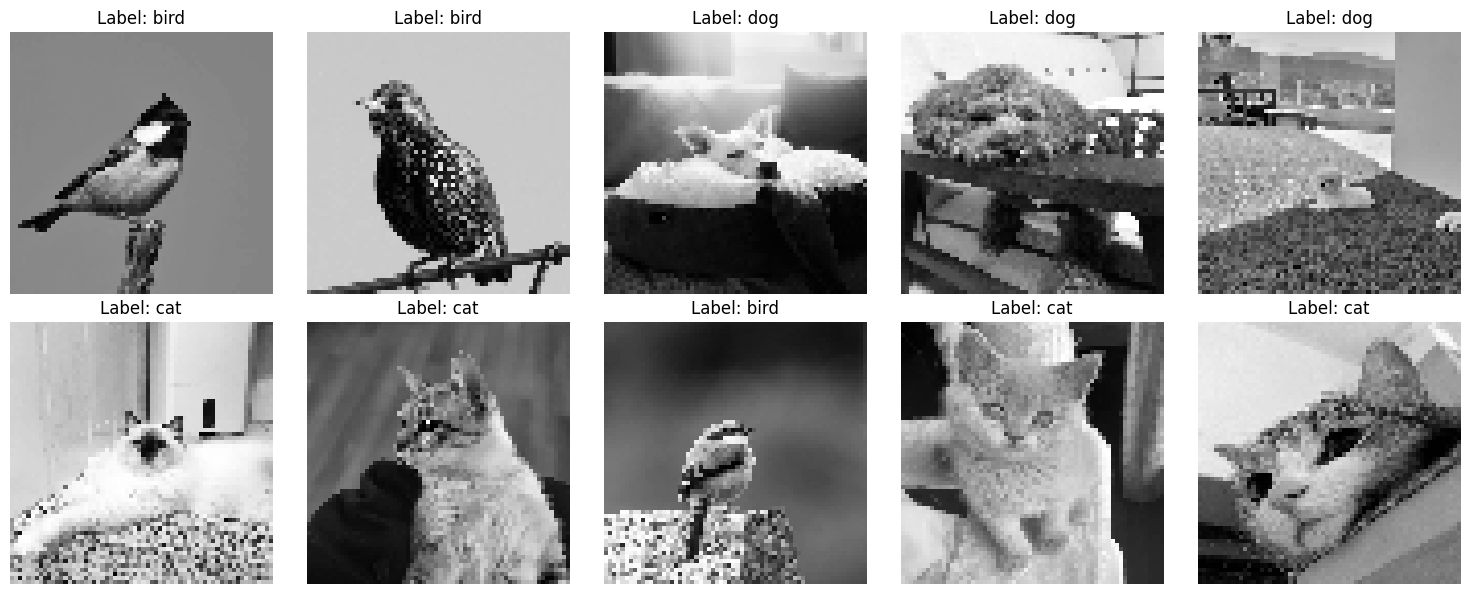

In [4]:
def print_data_summary(data_obj=None):
    # Initialize and use the data module
    if data_obj is None:
        data_module = DataModule(im_dim_target=64, batch_size=8)
    else:
        data_module = data_obj
    train_loader, val_loader, test_loader = data_module.get_dataloaders()
    print(f"Train loader: {len(train_loader)} batches, Val loader: {len(val_loader)} batches, Test loader: {len(test_loader)} batches")
    # get training data
    x_train, y_train, x_test, y_test, x_val, y_val = data_module.get_train_data()
    print(f"Train data shape: {x_train.shape}, Train labels shape: {y_train.shape}")
    print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")
    print(f"Validation data shape: {x_val.shape}, Validation labels shape: {y_val.shape}")
    # get training tensors
    x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, x_val_tensor, y_val_tensor = data_module.get_train_tensors()
    print(f"Train tensors shape: {x_train_tensor.shape}, Train labels shape: {y_train_tensor.shape}")
    print(f"Test tensors shape: {x_test_tensor.shape}, Test labels shape: {y_test_tensor.shape}")
    print(f"Validation tensors shape: {x_val_tensor.shape}, Validation labels shape: {y_val_tensor.shape}")
    classifications = data_module.get_class_map()
    print(f"Class map: {classifications}")
    # Display some sample images
    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x_train[i, 0], cmap='gray')
        plt.title(f"Label: {classifications[y_train[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
print_data_summary()  

### 1.3 **Model Configuration and Training**

In this section we will configure and train the Model

#### 1.3.1 **Model Configuration**
The model consists of three **convolutional layers** with **batch normalization**, **dropout**, and **max pooling** ,  
followed by two **fully connected** layers. The class also includes a convenient **predict** method 
for inference, which returns both the predicted class indices and class probabilities.

In [5]:
class CTNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.conv2a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn4 = nn.BatchNorm2d(1024)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout2d = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(2 * 2 * 1024, 256)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        # print(f"Input: {x.shape}")
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # 128,32,32
        # print(f"After conv1: {x.shape}")
        x = self.dropout2d(x)
        x = F.leaky_relu(self.bn2(self.conv2a(x)))
        # print(f"After dropout2d: {x.shape}")
        x = self.pool(F.leaky_relu(self.bn3(self.conv2b(x)))) # 256,16,16
        # print(f"After conv2: {x.shape}")
        x = self.dropout2d(x)
        x = F.leaky_relu(self.bn4(self.conv3(x)))
        # print(f"After dropout2d: {x.shape}")
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x)))) # 512,8,8
        # print(f"After conv3: {x.shape}")
        x = self.dropout2d(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x)))) # 512,4,4
        # print(f"After conv4: {x.shape}")
        x = self.dropout2d(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        # print(f"After dropout2d: {x.shape}")
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x)))) # 512,2,2
        # print(f"After conv5: {x.shape}")
        x = self.dropout2d(x)
        x = F.leaky_relu(self.bn4(self.conv4(x)))
        # print(f"After dropout2d: {x.shape}")
        x = x.view(x.size(0), -1)
        # print(f"After flattening: {x.shape}")
        # x = torch.pca_lowrank(x, q=32, center=True)[0]  # Apply PCA to reduce dimensionality 
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        # print(f"After dropout and fc1: {x.shape}")
        x = self.fc2(x)
        return x

    def predict(self, x, device=None):
        
        self.eval()
        if device is not None:
            self.to(device)
            x = x.to(device)
        with torch.no_grad():
            if x.dim() == 3:
                x = x.unsqueeze(0)  # Make batch dimension
            outputs = self.forward(x)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
        return preds, probs.cpu().numpy()

#### 1.3.2 **Model Training**

##### 1.3.2.1 **CTNNTrainer Module**
**CTNNTrainer** is a utility class for training, evaluating, saving, and loading project models using **PyTorch**. It manages the entire model training lifecycle, including **optimizer** and **scheduler** setup, hyperparameter management, model **versioning**, and **checkpointing**. The class also tracks metrics during training and validation, supports reusing existing models with identical training parameters, and saves comprehensive training metrics for later analysis.

In [6]:

# !pip install torch==2.3.1+cu121 torchvision==0.18.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html
print(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

cuda


In [7]:
class CTNNTrainer:
    def __init__(self, model, model_dir="./models", model_prefix="best_model",
                        params=None, device=None, lr=0.001, weight_decay=1e-4):
        self.model = model
        self.device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        self.model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), weight_decay=weight_decay, lr=lr)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=5)
        self.model_dir = model_dir
        os.makedirs(self.model_dir, exist_ok=True)
        self.model_prefix = model_prefix

        # Save current training parameters (add anything else relevant as needed!)
        self.train_params = params or {"lr": lr, "weight_decay": weight_decay}
        # Use these for filename versioning
        self.version = self._next_model_version()
        self.base_filename = f"{self.model_prefix}_v{self.version}"

        self.best_model_path = os.path.join(self.model_dir, f"{self.base_filename}.pth")
        self.params_path = self.best_model_path + ".params.json"
        self.metrics_path = os.path.join(self.model_dir, f"training_metrics_{self.version}.csv")
        self.metrics_history = {
            'epoch': [],
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }

    def _next_model_version(self):
        # Look for all models with this prefix
        files = glob.glob(os.path.join(self.model_dir, f"{self.model_prefix}_v*.pth"))
        versions = []
        pat = re.compile(rf"{re.escape(self.model_prefix)}_v(\d+)\.(\d+)\.pth$")
        for f in files:
            m = pat.search(os.path.basename(f))
            if m:
                versions.append((int(m.group(1)), int(m.group(2))))
        if not versions:
            return "1.0"
        versions.sort()
        latest_major, latest_minor = versions[-1]
        return f"{latest_major}.{latest_minor + 1}"

    @staticmethod
    def calculate_accuracy(model, data_loader, device):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        return accuracy

    def find_matching_model(self):
        """Checks for an existing model in models/ with matching params. If found, returns (model_path, params_path, metrics_path, version), else None."""
        files = glob.glob(os.path.join(self.model_dir, f"{self.model_prefix}_v*.pth"))
        pat = re.compile(rf"{re.escape(self.model_prefix)}_v(\d+)\.(\d+)\.pth$")
        for model_path in files:
            m = pat.search(os.path.basename(model_path))
            if m:
                version = f"{m.group(1)}.{m.group(2)}"
                params_path = model_path + ".params.json"
                if os.path.exists(params_path):
                    with open(params_path, 'r') as f:
                        params = json.load(f)
                    if params == self.train_params:
                        metrics_path = os.path.join(self.model_dir, f"training_metrics_{version}.csv")
                        return model_path, params_path, metrics_path, version
        return None

    def save_model_and_params(self):
        torch.save(self.model.state_dict(), self.best_model_path)
        with open(self.params_path, 'w') as f:
            json.dump(self.train_params, f)

    def load_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        print(f"\n[INFO] Loaded pre-trained model from {model_path}\n")

    def train(self, train_loader, val_loader, num_epochs=20, save_metrics=False, save_model=False):
        # Check for a matching model (by hyperparameters)
        match = self.find_matching_model()
        if match:
            model_path, params_path, metrics_path, version = match
            self.version = version
            self.base_filename = f"{self.model_prefix}_v{self.version}"
            self.best_model_path = model_path
            self.params_path = params_path
            self.metrics_path = metrics_path
            self.load_model(model_path)
            if os.path.isfile(self.metrics_path):
                print(f"[INFO] Found matching training metrics at {self.metrics_path}")
                df = pd.read_csv(self.metrics_path)
                print(df)
            else:
                print("[INFO] Metrics summary for this pretrained model not found!")
            return

        print(f"Training new model: saving as version v{self.version}")

        best_val_score = 0.0

        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
            for inputs, labels in train_pbar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                # print(inputs.shape)
                # print(labels.shape)
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * inputs.size(0)
            epoch_train_loss = running_loss / len(train_loader.dataset)
            epoch_train_acc = self.calculate_accuracy(self.model, train_loader, self.device)

            # Validation
            
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            self.model.eval()
            running_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_pbar:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    running_loss += loss.item() * inputs.size(0)
            
            epoch_val_loss = running_loss / len(val_loader.dataset)
            epoch_val_acc = self.calculate_accuracy(self.model, val_loader, self.device)
            self.scheduler.step(epoch_val_loss)
            print(f"Epoch {epoch+1}/{num_epochs} - "
                    f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
                    f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
            if(save_metrics or save_model):
                self.metrics_history['epoch'].append(epoch + 1)
                self.metrics_history['train_loss'].append(epoch_train_loss)
                self.metrics_history['train_acc'].append(epoch_train_acc)
                self.metrics_history['val_loss'].append(epoch_val_loss)
                self.metrics_history['val_acc'].append(epoch_val_acc)

                epoch_score = round((epoch_val_acc - (epoch_val_loss * 10) - epoch_train_loss), 4)
                if(save_model):
                    if epoch_score > best_val_score:
                        best_val_score = epoch_score
                        self.save_model_and_params()
                        self.load_model(self.best_model_path)

                

                # Save summary after training
                if(save_metrics):
                    self.save_metrics(self.metrics_path)
                    print(f"\n[INFO] Model and summary saved as: {self.base_filename}\n")
            

    def print_metrics_summary(self):
        df = pd.DataFrame(self.metrics_history)
        print("\nTraining summary by epoch:")
        print(df.to_string(index=False))

    def save_metrics(self, path=None):
        df = pd.DataFrame(self.metrics_history)
        path = path or self.metrics_path
        df.to_csv(path, index=False)
        print(f"Epoch metrics saved to {path}")

##### 1.3.2.2 Model Training

In [8]:
# define hyperparameters
learning_rate = 0.0001
num_epochs = 20
batch_size = 5
im_dim_target = 64  # Target image size for resizing

# Initialize and use the data module
data_module = DataModule(im_dim_target=im_dim_target, batch_size=batch_size)

# get training data
train_loader, val_loader, test_loader = data_module.get_dataloaders()
x_train, y_train, x_test, y_test, x_val, y_val = data_module.get_train_data()
# get training tensors
x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, x_val_tensor, y_val_tensor = data_module.get_train_tensors()
classifications = data_module.get_class_map()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CTNN().to(device)
print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CTNN().to(device)
# Initialize the trainer with the model and device
trainer = CTNNTrainer(model, device=device, lr=learning_rate, weight_decay=0.001)
trainer.train(train_loader, val_loader, num_epochs=num_epochs, save_metrics=False, save_model=False)
trainer.print_metrics_summary()
trainer.save_metrics()

Preprocessing complete. Data shape: (150, 4097)
CTNN(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bia

Epoch 1/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 138.89it/s]


Epoch 1/20 - Train Loss: 1.1852, Train Acc: 32.29% | Val Loss: 1.1007, Val Acc: 33.33%


Epoch 2/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 277.80it/s]


Epoch 2/20 - Train Loss: 1.1094, Train Acc: 34.38% | Val Loss: 1.1059, Val Acc: 33.33%


Epoch 3/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 277.76it/s]


Epoch 3/20 - Train Loss: 1.0522, Train Acc: 47.92% | Val Loss: 1.0837, Val Acc: 45.83%


Epoch 4/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 263.17it/s]


Epoch 4/20 - Train Loss: 0.9703, Train Acc: 54.17% | Val Loss: 1.0468, Val Acc: 66.67%


Epoch 5/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 266.22it/s]


Epoch 5/20 - Train Loss: 1.0524, Train Acc: 46.88% | Val Loss: 1.0583, Val Acc: 41.67%


Epoch 6/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 277.78it/s]


Epoch 6/20 - Train Loss: 1.0409, Train Acc: 58.33% | Val Loss: 0.9406, Val Acc: 58.33%


Epoch 7/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 263.21it/s]


Epoch 7/20 - Train Loss: 0.9958, Train Acc: 64.58% | Val Loss: 0.9583, Val Acc: 58.33%


Epoch 8/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 263.16it/s]


Epoch 8/20 - Train Loss: 0.9135, Train Acc: 54.17% | Val Loss: 0.9407, Val Acc: 45.83%


Epoch 9/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 277.78it/s]


Epoch 9/20 - Train Loss: 0.8478, Train Acc: 61.46% | Val Loss: 0.8802, Val Acc: 54.17%


Epoch 10/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 277.79it/s]


Epoch 10/20 - Train Loss: 0.8252, Train Acc: 38.54% | Val Loss: 1.4103, Val Acc: 41.67%


Epoch 11/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 263.18it/s]


Epoch 11/20 - Train Loss: 0.9306, Train Acc: 58.33% | Val Loss: 1.2650, Val Acc: 33.33%


Epoch 12/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 263.15it/s]


Epoch 12/20 - Train Loss: 0.8292, Train Acc: 67.71% | Val Loss: 0.8395, Val Acc: 70.83%


Epoch 13/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 277.78it/s]


Epoch 13/20 - Train Loss: 0.7304, Train Acc: 73.96% | Val Loss: 0.9288, Val Acc: 45.83%


Epoch 14/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 277.77it/s]


Epoch 14/20 - Train Loss: 0.7227, Train Acc: 68.75% | Val Loss: 0.9731, Val Acc: 45.83%


Epoch 15/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 249.99it/s]


Epoch 15/20 - Train Loss: 0.6865, Train Acc: 64.58% | Val Loss: 1.5381, Val Acc: 33.33%


Epoch 16/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 263.16it/s]


Epoch 16/20 - Train Loss: 0.6443, Train Acc: 67.71% | Val Loss: 0.9069, Val Acc: 54.17%


Epoch 17/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 277.79it/s]


Epoch 17/20 - Train Loss: 0.5226, Train Acc: 57.29% | Val Loss: 1.4159, Val Acc: 33.33%


Epoch 18/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 238.12it/s]


Epoch 18/20 - Train Loss: 0.4667, Train Acc: 88.54% | Val Loss: 1.1945, Val Acc: 58.33%


Epoch 19/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 277.79it/s]


Epoch 19/20 - Train Loss: 0.2447, Train Acc: 86.46% | Val Loss: 1.1905, Val Acc: 58.33%


Epoch 20/20 [Val]: 100%|██████████| 5/5 [00:00<00:00, 263.18it/s]


Epoch 20/20 - Train Loss: 0.2610, Train Acc: 87.50% | Val Loss: 1.2012, Val Acc: 66.67%

Training summary by epoch:
Empty DataFrame
Columns: [epoch, train_loss, train_acc, val_loss, val_acc]
Index: []
Epoch metrics saved to ./models\training_metrics_1.0.csv


## 2. **PCA Implementation**